In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data import dataset_Poisson2D_finite_diff, dataset_Krylov
from conj_grad import ConjGrad, apply_LLT
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data import direc_graph_from_linear_system_sparse
from train import train

# Setup experiment

In [3]:
grid = 32
N_samples_train = 20
N_samples_test = 5
rhs_train = [5, 5, 2]
rhs_test = [5, 5, 2]
random_rhs = True               # If True rhs is random, then `rhs_train` and `rhs_test` ignored

cg_repeats = 100                 # Ignore

In [4]:
layer_ = ConstantConv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
loss_type = 'notay'               # Either 'llt' or 'notay'
with_cond = True               # If True will calculate cond during training. Extremly bad scaling (materialization of matrix)
with_final_cond = True         # If True will calculate cond with final L. Also bad scaling

In [5]:
batch_size = 64
lr = 1e-3
epoch_num = 70

In [6]:
# Uncomment and setup to make steps in learning rate

# steps_per_batch = N_samples_train // batch_size
# start, stop, step = 20*steps_per_batch, 101*steps_per_batch, 20*steps_per_batch
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
# #     {k: v for k, v in zip([37], [1e-1])}
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

# Make dataset

In [7]:
# A_train, b_train, u_exact_train, bi_edges_train = dataset_Poisson2D_finite_diff(grid, N_samples_train, seed=42, rhs_distr=rhs_train, random_rhs=random_rhs)
# A_test, b_test, u_exact_test, bi_edges_test = dataset_Poisson2D_finite_diff(grid, N_samples_test, seed=43, rhs_distr=rhs_test, random_rhs=random_rhs)

In [8]:
A_train, b_train, u_exact_train, bi_edges_train, res_train = dataset_Krylov(grid, N_samples_train, seed=42, rhs_distr=rhs_train, cg_repeats=cg_repeats, random_rhs=random_rhs)
A_test, b_test, u_exact_test, bi_edges_test, res_test = dataset_Krylov(grid, N_samples_test, seed=43, rhs_distr=rhs_test, cg_repeats=cg_repeats, random_rhs=random_rhs)

2024-04-16 11:55:34.689756: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Train model

In [9]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),    
    update_node_fn = FullyConnectedNet(features=[32, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2753


In [10]:
# data = (X_train, X_test, y_train, y_test)
data = (
#     [A_train, b_train, bi_edges_train, u_exact_train],
#     [A_test, b_test, bi_edges_test, u_exact_test],
    [A_train, b_train, bi_edges_train, u_exact_train, res_train],
    [A_test, b_test, bi_edges_test, u_exact_test, res_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size
}

### Pre-train with $LL^T$ loss 

In [11]:
# batch_size = 4
# lr = 1e-2

# # steps_per_batch = N_samples_train // batch_size
# # start, stop, step = 20*steps_per_batch, 101*steps_per_batch, 20*steps_per_batch
# # decay_size = 1e-1
# # lr = optax.piecewise_constant_schedule(
# #     lr,
# # #     {k: v for k, v in zip([37], [1e-1])}
# #     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# # )
# pretrain_train_config = {
#     'optimizer': optax.adam,
#     'lr': lr,
#     'optim_params': {},#{'weight_decay': 1e-8}, 
#     'epoch_num': 150,
#     'batch_size': batch_size
# }
# model, losses_pre = train(model, data, pretrain_train_config, loss_name='llt', with_cond=True)

-----

In [12]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, with_cond=with_cond, repeat_step=cg_repeats)
print(perf_counter() - s)

464.18052239343524


In [13]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test, b_test)[:-1], bi_edges_test)
del model, data, A_train, b_train, u_exact_train, bi_edges_train, res_train, res_test
clear_caches()

Final values
  train loss: 1.0000
   test loss: 1.0000
    LLT cond: nan

Minimim test loss `0.5289` at epoch `21`

Minimim test P^(-1)A cond `nan` at epoch `68`

Test lhs A cond: 441, test P^(-1)A cond: nan


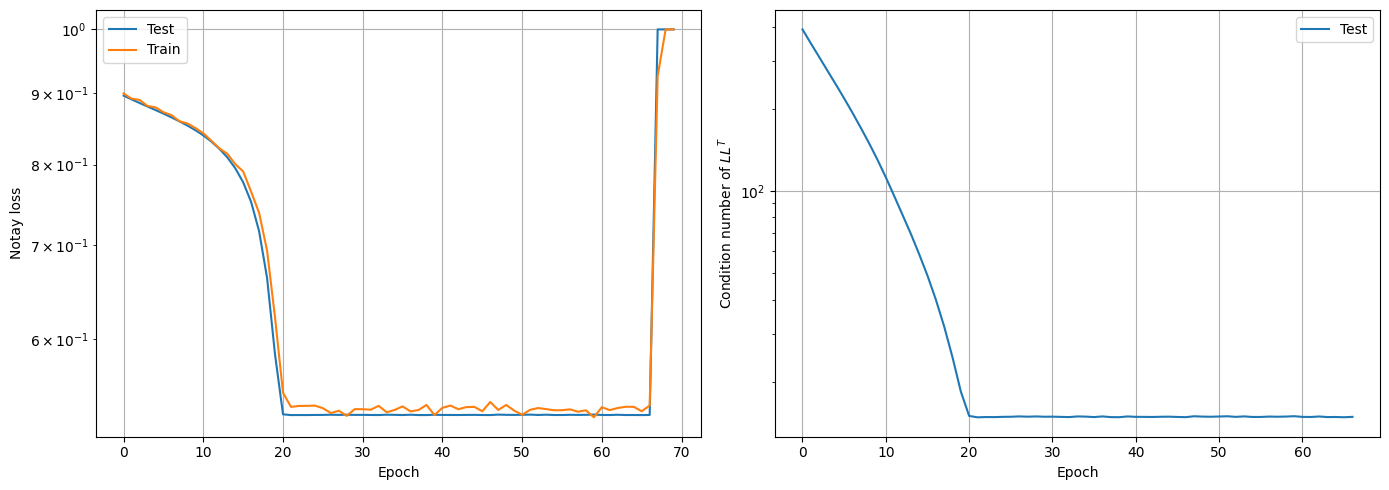

In [14]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# No pre-train
axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')

# # With pre-train
# axes[0].plot(range(len(losses_pre[0])), losses_pre[1], label='Test')
# axes[0].plot(range(len(losses_pre[0])), losses_pre[0], label='Train')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[1], label='Test')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[0], label='Train')

axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Notay loss');
axes[0].grid();


if with_cond:
    # No pre-train
    axes[1].plot(range(len(losses[0])), losses[2], label='Test')

    # With pre-train
    # axes[1].plot(range(len(losses_pre[0])), losses_pre[2], label='Test')
    # axes[1].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[2], label='Test')

    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Condition number of $LL^T$')
    axes[1].grid();


# axes[0].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# axes[1].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# for vl in [28]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')
plt.tight_layout()


if with_cond: 
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
    print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
else:
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
if with_final_cond:
    cond_A, cond_LLT = jit(asses_cond)(A_test[::cg_repeats, ...], L[::cg_repeats, ...])
    print(f'\nTest lhs A cond: {cond_A:.0f}, test P^(-1)A cond: {cond_LLT:.0f}')

# Apply model to CG

In [15]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=300, prec_func=None, seed=42)

In [16]:
# Prec = LL^T
prec = partial(apply_LLT, L=L)

X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=300, prec_func=prec, seed=42)

        Simple CG: {0.001: 73, 1e-06: 99, 1e-12: 162}
Preconditioned CG: {0.001: nan, 1e-06: nan, 1e-12: nan}


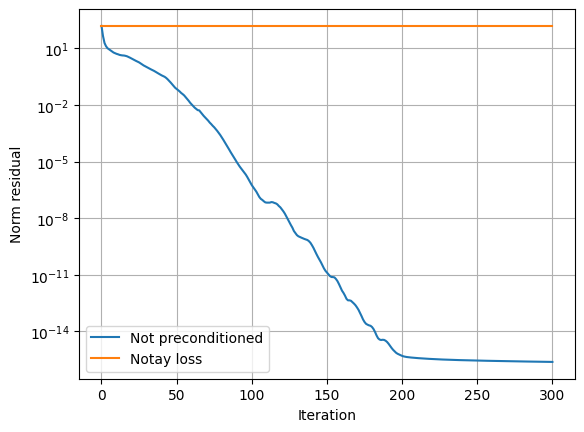

In [17]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="Notay loss")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines(110, 1e-15, 1, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

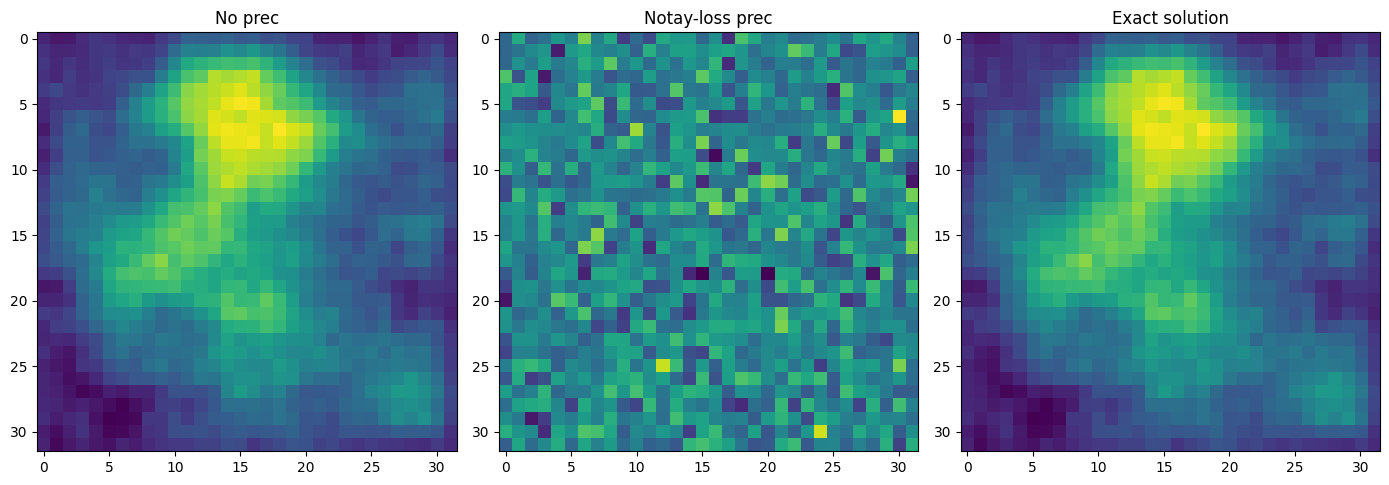

In [18]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()